In [1]:
import argparse
import copy
import torch.optim as optim

from utils import *
from modules import *

import matplotlib.pyplot as plt

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--cuda', action='store_true', default=True, help='Disables CUDA training.')
parser.add_argument('--batch-size', type=int, default=128, help='Number of samples per batch.')
parser.add_argument('--encoder-hidden', type=int, default=64, help='Number of hidden units.')
parser.add_argument('--decoder-hidden', type=int, default=64, help='Number of hidden units.')
parser.add_argument('--epochs_adam', type=int, default=1000, help='Number of epochs to train.')
parser.add_argument('--lag', action='store_true', default=2, help='Lag in the Granger causality model.')
parser.add_argument('--lr', action='store_true', default=1e-3, help='Learning rate.')
parser.add_argument('--lmbd-prox', action='store_true', default=1e-2, help='Proximal lambda parameter.')
parser.add_argument('--lmbd-ridge', action='store_true', default=1e-2, help='Proximal lambda parameter.')
parser.add_argument('--num-atoms', type=int, default=10, help='Number of atoms in simulation.')
parser.add_argument('--prediction-steps', type=int, default=3, help='Random seed.')
parser.add_argument('--prior', type=int, default=0.25, help='Random seed.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--stationary', action='store_true', default=True, help='Each time series is stationary.')
parser.add_argument('--suffix', type=str, default='_springs10', help='Suffix for training data (e.g. "_charged".')

args, unknown = parser.parse_known_args()
args.cuda = args.cuda and torch.cuda.is_available()

args.path = '/data/tsi/analyse_de_donnees/04-Data/Springs/Datasets/different_graph/'

print(args)

Namespace(batch_size=128, cuda=True, decoder_hidden=64, encoder_hidden=64, epochs_adam=1000, lag=2, lmbd_prox=0.01, lmbd_ridge=0.01, lr=0.001, num_atoms=10, path='/data/tsi/analyse_de_donnees/04-Data/Springs/Datasets/different_graph/', prediction_steps=3, prior=0.25, seed=42, stationary=True, suffix='_springs10')


### Utils

In [122]:
def train(epoch, rnn_encoder, out_encoder, optimizer_encoder, train_loader):
    loss_train, reg_train = [], []
    for batch_idx, (data, label, relations) in enumerate(train_loader):
        optimizer_encoder.zero_grad()
                
        X = torch.transpose(copy.deepcopy(data), 1, 2)
        X = X.contiguous().view(X.size(0), X.size(1), -1)
        if args.cuda:
            X = X.cuda()
            label = label.cuda()
            relations = relations.cuda()
            
        _, W = rnn_encoder(X)
        W = torch.stack([o(torch.transpose(W[-2:], 0, 1).contiguous().view(data.size(0), -1)) for o in out_encoder], -1)
        W = W.contiguous().view(data.size(0), args.num_atoms, args.num_atoms, args.lag)
        
        del X
        torch.cuda.empty_cache
        
        if args.cuda:
            data = data.cuda()
        
        preds = 0
        for t in range(args.lag):
            preds += torch.bmm(W[:, :, :, t],
                               data[:, :, t:data.size(2)-args.lag+t].view(data.size(0), data.size(1), -1))

        target = data[:, :, args.lag:].view(data.size(0), data.size(1), -1)
        loss = ((preds - target)**2).mean(0).sum()
        
        reg = torch.sqrt(torch.sum(W**2, dim=3)).sum()
        
        loss.backward()
        optimizer_encoder.step()
        
        loss_train.append(loss.item())
        reg_train.append(reg.item())
    
    print('Epoch: {:04d}'.format(epoch), 'loss: {:.5f}'.format(np.mean(loss_train)), 
          'reg: {:.5f}'.format(np.mean(reg_train)))
    return np.mean(loss_train)

In [123]:
def test(epoch, rnn_encoder, out_encoder, test_loader):
    loss_test, reg_test = [], []
    for batch_idx, (data, label, relations) in enumerate(test_loader):
        
        X = torch.transpose(copy.deepcopy(data[:, :, :args.timesteps]), 1, 2)
        X = X.contiguous().view(X.size(0), X.size(1), -1)
        if args.cuda:
            X = X.cuda()
            label = label.cuda()
            relations = relations.cuda()
            
        _, W = rnn_encoder(X)
        W = torch.stack([o(torch.transpose(W[-2:], 0, 1).contiguous().view(data.size(0), -1)) for o in out_encoder], -1)
        W = W.contiguous().view(data.size(0), args.num_atoms, args.num_atoms, args.lag)
        
        del X
        torch.cuda.empty_cache
        
        if args.cuda:
            data = data.cuda()
        
        preds = 0
        for t in range(args.lag):
            preds += torch.bmm(W[:, :, :, t],
                               data[:, :, t:data.size(2)-args.lag+t].view(data.size(0), data.size(1), -1))

        target = data[:, :, args.lag:].view(data.size(0), data.size(1), -1)
        loss = ((preds - target)**2).mean(0).sum()
        
        reg = torch.sqrt(torch.sum(W**2, dim=3)).sum()
        
        loss_test.append(loss.item())
        reg_test.append(reg.item())
    
    print('Epoch: {:04d}'.format(epoch), 'loss: {:.5f}'.format(np.mean(loss_test)), 
          'reg: {:.5f}'.format(np.mean(reg_test)))
    return np.mean(loss_test)

In [109]:
def causality_estimation(rnn_encoder, out_encoder, test_loader):
    sparsity_estimation = []
    W_dataset, rel_dataset = [], []
    
    for batch_idx, (data, label, relations) in enumerate(test_loader):
        
        X = torch.transpose(copy.deepcopy(data[:, :, :args.timesteps]), 1, 2)
        X = X.contiguous().view(data.size(0), args.timesteps, -1)
        if args.cuda:
            X = X.cuda()
            label = label.cuda()
            relations = relations.cuda()
            
        _, W = rnn_encoder(X)
        W = torch.stack([o(torch.transpose(W[-2:], 0, 1).contiguous().view(data.size(0), -1)) for o in out_encoder], -1)
        W = W.contiguous().view(data.size(0), args.num_atoms, args.num_atoms, args.lag)
        rel = torch.ones(relations.size(0), args.num_atoms, args.num_atoms).float()
        for i in range(args.num_atoms):
            rel[:, i, [k for k in range(args.num_atoms) if k != i]] = relations[:, i*(args.num_atoms-1):(i+1)*(args.num_atoms-1)].cpu().float()

        sparsity_estimation.append((rel == (W.abs().sum(-1) > np.percentile(W.abs().sum(-1).cpu().detach(), q=50)).float().detach().cpu()).float().mean().item())

        W_dataset.append((W.abs().sum(-1) > np.percentile(W.abs().sum(-1).cpu().detach(), q=50)).float().detach().cpu())
        rel_dataset.append(rel.float().detach().cpu())
        
    rel_est_dataset = torch.cat(W_dataset)
    rel_dataset = torch.cat(rel_dataset)
    
    tp = (rel_dataset.view(rel_dataset.size(0), -1)*rel_est_dataset.view(rel_est_dataset.size(0), -1)).sum()
    fp = ((1-rel_dataset.view(rel_dataset.size(0), -1))*rel_est_dataset.view(rel_est_dataset.size(0), -1)).sum()
    fn = (rel_dataset.view(rel_dataset.size(0), -1)*(1-rel_est_dataset.view(rel_est_dataset.size(0), -1))).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    F_score = 2*precision*recall/(precision+recall)
    
    return precision.item(), recall.item(), F_score.item()

### Permutation experiments

In [129]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

args.num_atoms = 10
args.timesteps = 25
args.lag = 1
args.in_dim = 1

def permutation_TS(p, T, P, seed):
    np.random.seed(seed)
    v = np.random.randn(p, T)
    for i in range(1, T):
        v[:, i] = np.matmul(P, v[:, i-1])
    return v

def generate_permutation_ts(p, T, n_class, n_samples_per_class, sd=0):
    
    seeds_W = np.random.choice(range(1000), n_class, replace=False)
    samples, Ws, labels, initial_cond = [], [], [], []
    matrices_labels = {}
    for i, sw in enumerate(seeds_W):
        
        p_ind = list(range(p))
        np.random.shuffle(p_ind)
        while np.sum([int(p_ind[i]==i) for i in range(args.num_atoms)]) > 0:
            np.random.shuffle(p_ind)
        P = np.eye(args.num_atoms)[np.ix_(range(args.num_atoms), p_ind)]
        matrices_labels[i] = P
        seeds_sample = np.random.choice(range(1000), n_samples_per_class, replace=False)
        
        for seed in seeds_sample:
            X = permutation_TS(p, T, P, seed)
            samples.append(X)
            labels.append(i)
            
    samples = np.stack(samples)
    labels = np.stack(labels)
    print(samples.shape)
    samples[:, :, 1:] = samples[:, :, 1:] + np.random.randn(*samples[:, :, 1:].shape)*sd
    
    return samples, matrices_labels, labels

In [142]:
def causality_estimation(rnn_encoder, out_encoder, test_loader):
    sparsity_estimation = []
    W_dataset, rel_dataset = [], []
    
    for batch_idx, (data, label, relations) in enumerate(test_loader):
        
        X = torch.transpose(copy.deepcopy(data[:, :, :args.timesteps]), 1, 2)
        X = X.contiguous().view(data.size(0), args.timesteps, -1)
        if args.cuda:
            X = X.cuda()
            label = label.cuda()
            
        _, W = rnn_encoder(X)
        W = torch.stack([o(torch.transpose(W[-2:], 0, 1).contiguous().view(data.size(0), -1)) for o in out_encoder], -1)
        W = W.contiguous().view(data.size(0), args.num_atoms, args.num_atoms, args.lag)
        
        W_dataset.append((W.abs().sum(-1) > np.percentile(W.abs().sum(-1).cpu().detach(), q=50)).float().detach().cpu())
        sparsity_estimation.append((relations == W_dataset[-1]).float().mean().item())

        
        rel_dataset.append(relations.float().detach().cpu())
        
    rel_est_dataset = torch.cat(W_dataset)
    rel_dataset = torch.cat(rel_dataset)
    
    tp = (rel_dataset*rel_est_dataset).sum()
    fp = ((1-rel_dataset)*rel_est_dataset).sum()
    fn = (rel_dataset*(1-rel_est_dataset)).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    F_score = 2*precision*recall/(precision+recall)
    
    return precision.item(), recall.item(), F_score.item()

In [131]:
args.sd = 0.1

X_train, W_train, labels_train = generate_permutation_ts(args.num_atoms, args.timesteps, 10, 100, sd=args.sd)
X_test, W_test, labels_test = generate_permutation_ts(args.num_atoms, args.timesteps, 10, 100, sd=args.sd)

X_train = torch.FloatTensor(X_train).unsqueeze(-1)
labels_train = torch.FloatTensor(labels_train)
rel_train = torch.FloatTensor(np.stack([W_train[l.item()] for l in labels_train]))
X_test = torch.FloatTensor(X_test).unsqueeze(-1)
labels_test = torch.FloatTensor(labels_test)
rel_test = torch.FloatTensor(np.stack([W_test[l.item()] for l in labels_test]))

train_data = TensorDataset(X_train, labels_train, rel_train)
train_data_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)

test_data = TensorDataset(X_test, labels_test, rel_test)
test_data_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=True)

(1000, 10, 25)
(1000, 10, 25)


In [132]:
rnn_encoder = nn.GRU(args.num_atoms*args.in_dim, 64, num_layers=2, batch_first=True, bidirectional=True)
out_encoder = nn.ModuleList([nn.Linear(128, args.num_atoms**2) for _ in range(args.lag)])

if args.cuda:
    rnn_encoder = rnn_encoder.cuda()
    out_encoder = out_encoder.cuda()
    
optimizer_encoder = optim.Adam(list(rnn_encoder.parameters()) + list(out_encoder.parameters()))

init_weights(rnn_encoder)
init_weights(out_encoder)

In [133]:
loss_train, loss_test = [test(-1, rnn_encoder, out_encoder, train_data_loader)[-1]], [test(-1, rnn_encoder, out_encoder, test_data_loader)[-1]]
causality_train, causality_test = [causality_estimation(rnn_encoder, out_encoder, train_data_loader)], [causality_estimation(rnn_encoder, out_encoder, test_data_loader)]

for epoch in range(args.epochs_adam):
    loss_train.append(train(epoch, rnn_encoder, out_encoder, optimizer_encoder, train_data_loader))
    loss_test.append(test(epoch, rnn_encoder, out_encoder, test_data_loader))
    causality_train.append(causality_estimation(rnn_encoder, out_encoder, train_data_loader)[-1])
    causality_test.append(causality_estimation(rnn_encoder, out_encoder, test_data_loader)[-1])

Epoch: -001 loss: 241.08700 reg: 1.66500
Epoch: -001 loss: 243.09366 reg: 1.65096
Epoch: 0000 loss: 237.39467 reg: 54.09393
Epoch: 0000 loss: 236.60270 reg: 181.85056
Epoch: 0001 loss: 215.98830 reg: 528.04077
Epoch: 0001 loss: 234.42987 reg: 1358.55943
Epoch: 0002 loss: 193.38247 reg: 1470.35446
Epoch: 0002 loss: 231.09930 reg: 1153.97690
Epoch: 0003 loss: 188.95063 reg: 1174.58977
Epoch: 0003 loss: 242.73415 reg: 1282.93515
Epoch: 0004 loss: 188.42809 reg: 1249.44189
Epoch: 0004 loss: 237.97455 reg: 1204.87640
Epoch: 0005 loss: 187.70671 reg: 1267.46083
Epoch: 0005 loss: 238.78967 reg: 1323.09647
Epoch: 0006 loss: 187.62854 reg: 1321.76411
Epoch: 0006 loss: 235.73330 reg: 1279.61063
Epoch: 0007 loss: 187.68375 reg: 1283.40167
Epoch: 0007 loss: 238.00608 reg: 1291.45641
Epoch: 0008 loss: 187.76296 reg: 1286.12958
Epoch: 0008 loss: 238.44132 reg: 1273.12524
Epoch: 0009 loss: 187.54571 reg: 1268.59563
Epoch: 0009 loss: 237.30032 reg: 1286.34746
Epoch: 0010 loss: 187.31721 reg: 1303.0309

Epoch: 0093 loss: 331.01239 reg: 1706.50537
Epoch: 0094 loss: 22.79578 reg: 1549.61526
Epoch: 0094 loss: 292.18841 reg: 1593.37083
Epoch: 0095 loss: 13.77689 reg: 1561.95897
Epoch: 0095 loss: 287.86626 reg: 1573.19969
Epoch: 0096 loss: 9.27288 reg: 1527.32487
Epoch: 0096 loss: 291.44230 reg: 1574.13719
Epoch: 0097 loss: 7.33360 reg: 1476.01210
Epoch: 0097 loss: 287.55044 reg: 1543.44594
Epoch: 0098 loss: 6.43214 reg: 1434.98975
Epoch: 0098 loss: 293.60486 reg: 1536.82173
Epoch: 0099 loss: 5.79479 reg: 1405.02071
Epoch: 0099 loss: 293.06454 reg: 1525.80682
Epoch: 0100 loss: 5.49835 reg: 1390.32611
Epoch: 0100 loss: 295.78423 reg: 1529.77405
Epoch: 0101 loss: 5.34352 reg: 1380.29037
Epoch: 0101 loss: 297.77131 reg: 1527.19955
Epoch: 0102 loss: 5.23223 reg: 1376.46265
Epoch: 0102 loss: 298.95978 reg: 1529.38129
Epoch: 0103 loss: 5.15766 reg: 1369.91460
Epoch: 0103 loss: 299.24371 reg: 1528.43651
Epoch: 0104 loss: 5.10111 reg: 1365.39391
Epoch: 0104 loss: 299.52267 reg: 1531.33836
Epoch: 0

Epoch: 0189 loss: 4.64293 reg: 1333.16869
Epoch: 0189 loss: 315.32891 reg: 1549.28937
Epoch: 0190 loss: 4.63657 reg: 1332.34911
Epoch: 0190 loss: 315.67611 reg: 1552.10202
Epoch: 0191 loss: 4.64517 reg: 1334.71387
Epoch: 0191 loss: 315.60191 reg: 1549.89795
Epoch: 0192 loss: 4.63707 reg: 1332.03725
Epoch: 0192 loss: 316.38185 reg: 1552.95206
Epoch: 0193 loss: 4.63531 reg: 1332.50885
Epoch: 0193 loss: 314.94654 reg: 1549.77364
Epoch: 0194 loss: 4.64079 reg: 1333.24837
Epoch: 0194 loss: 315.88459 reg: 1552.40714
Epoch: 0195 loss: 4.64137 reg: 1332.81221
Epoch: 0195 loss: 315.84567 reg: 1552.65158
Epoch: 0196 loss: 4.64199 reg: 1332.72803
Epoch: 0196 loss: 316.72028 reg: 1553.76109
Epoch: 0197 loss: 4.63003 reg: 1332.47972
Epoch: 0197 loss: 315.46569 reg: 1552.95143
Epoch: 0198 loss: 4.62374 reg: 1331.56801
Epoch: 0198 loss: 317.19040 reg: 1552.60927
Epoch: 0199 loss: 4.62102 reg: 1331.86639
Epoch: 0199 loss: 315.96646 reg: 1553.71359
Epoch: 0200 loss: 4.63133 reg: 1332.39227
Epoch: 0200 

Epoch: 0284 loss: 319.21235 reg: 1561.37880
Epoch: 0285 loss: 4.55667 reg: 1335.23727
Epoch: 0285 loss: 318.98034 reg: 1561.97197
Epoch: 0286 loss: 4.56882 reg: 1336.09970
Epoch: 0286 loss: 318.70024 reg: 1564.22015
Epoch: 0287 loss: 4.55164 reg: 1335.59705
Epoch: 0287 loss: 318.60199 reg: 1561.80267
Epoch: 0288 loss: 4.55692 reg: 1335.00064
Epoch: 0288 loss: 318.13859 reg: 1564.71013
Epoch: 0289 loss: 4.55750 reg: 1334.57571
Epoch: 0289 loss: 319.04676 reg: 1561.15378
Epoch: 0290 loss: 4.55002 reg: 1334.76685
Epoch: 0290 loss: 319.15405 reg: 1564.19855
Epoch: 0291 loss: 4.54508 reg: 1333.87534
Epoch: 0291 loss: 319.03075 reg: 1564.26944
Epoch: 0292 loss: 4.54685 reg: 1333.91629
Epoch: 0292 loss: 318.83380 reg: 1559.33746
Epoch: 0293 loss: 4.55292 reg: 1335.47835
Epoch: 0293 loss: 319.45216 reg: 1562.19630
Epoch: 0294 loss: 4.54138 reg: 1333.31815
Epoch: 0294 loss: 319.31153 reg: 1563.48122
Epoch: 0295 loss: 4.54329 reg: 1334.75815
Epoch: 0295 loss: 319.24238 reg: 1565.77327
Epoch: 029

Epoch: 0380 loss: 4.49067 reg: 1342.06407
Epoch: 0380 loss: 318.99113 reg: 1574.00447
Epoch: 0381 loss: 4.48644 reg: 1341.54478
Epoch: 0381 loss: 319.85652 reg: 1572.00305
Epoch: 0382 loss: 4.49001 reg: 1341.51414
Epoch: 0382 loss: 319.43853 reg: 1570.36386
Epoch: 0383 loss: 4.48260 reg: 1340.72037
Epoch: 0383 loss: 319.15242 reg: 1569.97565
Epoch: 0384 loss: 4.47457 reg: 1340.24518
Epoch: 0384 loss: 320.09423 reg: 1571.66779
Epoch: 0385 loss: 4.47253 reg: 1339.91626
Epoch: 0385 loss: 318.42724 reg: 1573.39737
Epoch: 0386 loss: 4.47128 reg: 1340.52106
Epoch: 0386 loss: 319.69398 reg: 1574.74316
Epoch: 0387 loss: 4.47222 reg: 1340.53618
Epoch: 0387 loss: 319.56728 reg: 1576.10649
Epoch: 0388 loss: 4.46921 reg: 1340.71266
Epoch: 0388 loss: 319.50807 reg: 1576.92924
Epoch: 0389 loss: 4.47053 reg: 1340.61139
Epoch: 0389 loss: 319.31260 reg: 1575.03824
Epoch: 0390 loss: 4.47900 reg: 1342.21295
Epoch: 0390 loss: 318.34939 reg: 1570.28217
Epoch: 0391 loss: 4.47566 reg: 1340.98804
Epoch: 0391 

Epoch: 0475 loss: 318.83693 reg: 1592.53334
Epoch: 0476 loss: 4.42665 reg: 1351.16084
Epoch: 0476 loss: 318.70461 reg: 1592.60365
Epoch: 0477 loss: 4.42743 reg: 1352.18936
Epoch: 0477 loss: 318.70562 reg: 1587.98918
Epoch: 0478 loss: 4.41387 reg: 1350.60196
Epoch: 0478 loss: 318.43387 reg: 1586.22774
Epoch: 0479 loss: 4.40494 reg: 1349.53944
Epoch: 0479 loss: 319.27295 reg: 1584.49445
Epoch: 0480 loss: 4.40108 reg: 1349.56453
Epoch: 0480 loss: 318.66531 reg: 1589.14958
Epoch: 0481 loss: 4.40509 reg: 1349.59488
Epoch: 0481 loss: 319.11346 reg: 1587.64639
Epoch: 0482 loss: 4.40472 reg: 1350.51422
Epoch: 0482 loss: 318.99859 reg: 1590.16837
Epoch: 0483 loss: 4.40672 reg: 1350.39288
Epoch: 0483 loss: 320.17917 reg: 1588.83940
Epoch: 0484 loss: 4.41076 reg: 1351.07796
Epoch: 0484 loss: 318.71937 reg: 1587.61751
Epoch: 0485 loss: 4.42334 reg: 1353.39287
Epoch: 0485 loss: 319.78039 reg: 1595.39171
Epoch: 0486 loss: 4.42866 reg: 1353.64931
Epoch: 0486 loss: 319.12701 reg: 1591.43779
Epoch: 048

Epoch: 0571 loss: 4.32883 reg: 1360.07231
Epoch: 0571 loss: 318.30252 reg: 1608.30588
Epoch: 0572 loss: 4.32879 reg: 1360.91092
Epoch: 0572 loss: 317.76986 reg: 1607.26273
Epoch: 0573 loss: 4.33733 reg: 1360.85103
Epoch: 0573 loss: 317.87864 reg: 1612.97986
Epoch: 0574 loss: 4.33463 reg: 1361.50700
Epoch: 0574 loss: 318.36783 reg: 1609.75269
Epoch: 0575 loss: 4.33202 reg: 1361.84470
Epoch: 0575 loss: 318.53039 reg: 1610.95396
Epoch: 0576 loss: 4.34063 reg: 1362.06520
Epoch: 0576 loss: 318.29008 reg: 1615.39821
Epoch: 0577 loss: 4.34098 reg: 1363.31940
Epoch: 0577 loss: 317.91897 reg: 1604.13475
Epoch: 0578 loss: 4.33912 reg: 1362.81700
Epoch: 0578 loss: 318.91355 reg: 1608.18454
Epoch: 0579 loss: 4.33232 reg: 1363.31931
Epoch: 0579 loss: 316.77358 reg: 1605.01250
Epoch: 0580 loss: 4.32941 reg: 1361.92509
Epoch: 0580 loss: 318.31759 reg: 1603.68616
Epoch: 0581 loss: 4.31893 reg: 1361.87401
Epoch: 0581 loss: 318.26285 reg: 1605.44160
Epoch: 0582 loss: 4.32048 reg: 1361.07184
Epoch: 0582 

Epoch: 0666 loss: 316.17788 reg: 1629.15474
Epoch: 0667 loss: 4.25437 reg: 1375.09084
Epoch: 0667 loss: 316.02411 reg: 1630.73695
Epoch: 0668 loss: 4.25532 reg: 1374.69017
Epoch: 0668 loss: 317.49356 reg: 1635.74529
Epoch: 0669 loss: 4.25621 reg: 1375.64832
Epoch: 0669 loss: 316.45549 reg: 1630.64709
Epoch: 0670 loss: 4.25041 reg: 1375.56847
Epoch: 0670 loss: 316.66232 reg: 1631.63239
Epoch: 0671 loss: 4.24630 reg: 1374.83218
Epoch: 0671 loss: 317.44286 reg: 1636.73376
Epoch: 0672 loss: 4.24542 reg: 1374.60210
Epoch: 0672 loss: 316.44357 reg: 1631.83937
Epoch: 0673 loss: 4.24720 reg: 1375.47174
Epoch: 0673 loss: 316.47015 reg: 1630.64955
Epoch: 0674 loss: 4.24406 reg: 1376.05458
Epoch: 0674 loss: 316.65378 reg: 1630.83803
Epoch: 0675 loss: 4.23983 reg: 1375.87427
Epoch: 0675 loss: 316.44534 reg: 1634.83345
Epoch: 0676 loss: 4.24056 reg: 1376.11041
Epoch: 0676 loss: 315.41169 reg: 1633.71466
Epoch: 0677 loss: 4.25070 reg: 1377.96135
Epoch: 0677 loss: 315.58638 reg: 1633.37527
Epoch: 067

Epoch: 0762 loss: 4.16346 reg: 1391.55928
Epoch: 0762 loss: 315.26609 reg: 1655.17317
Epoch: 0763 loss: 4.15928 reg: 1391.31070
Epoch: 0763 loss: 313.99977 reg: 1653.99362
Epoch: 0764 loss: 4.15966 reg: 1391.28442
Epoch: 0764 loss: 315.70766 reg: 1656.66571
Epoch: 0765 loss: 4.16071 reg: 1391.13026
Epoch: 0765 loss: 314.22627 reg: 1651.38235
Epoch: 0766 loss: 4.15474 reg: 1391.00981
Epoch: 0766 loss: 315.13809 reg: 1656.18269
Epoch: 0767 loss: 4.15340 reg: 1391.47169
Epoch: 0767 loss: 315.41409 reg: 1654.27324
Epoch: 0768 loss: 4.14852 reg: 1391.27786
Epoch: 0768 loss: 315.13174 reg: 1656.05917
Epoch: 0769 loss: 4.14917 reg: 1391.76895
Epoch: 0769 loss: 315.09012 reg: 1656.21600
Epoch: 0770 loss: 4.15187 reg: 1392.75890
Epoch: 0770 loss: 314.83317 reg: 1657.82587
Epoch: 0771 loss: 4.14778 reg: 1392.72026
Epoch: 0771 loss: 314.76013 reg: 1651.96877
Epoch: 0772 loss: 4.14315 reg: 1391.97047
Epoch: 0772 loss: 314.42012 reg: 1652.90329
Epoch: 0773 loss: 4.13999 reg: 1392.26933
Epoch: 0773 

Epoch: 0857 loss: 302.56855 reg: 1610.88898
Epoch: 0858 loss: 4.17664 reg: 1398.30879
Epoch: 0858 loss: 302.61031 reg: 1611.25203
Epoch: 0859 loss: 4.17383 reg: 1397.24950
Epoch: 0859 loss: 302.52490 reg: 1614.35318
Epoch: 0860 loss: 4.17068 reg: 1397.89407
Epoch: 0860 loss: 302.01362 reg: 1612.17233
Epoch: 0861 loss: 4.16270 reg: 1398.59076
Epoch: 0861 loss: 302.76568 reg: 1616.20741
Epoch: 0862 loss: 4.16003 reg: 1397.49916
Epoch: 0862 loss: 301.69820 reg: 1614.70078
Epoch: 0863 loss: 4.15842 reg: 1398.12323
Epoch: 0863 loss: 302.76557 reg: 1614.12874
Epoch: 0864 loss: 4.15555 reg: 1398.26299
Epoch: 0864 loss: 302.05076 reg: 1615.25914
Epoch: 0865 loss: 4.15638 reg: 1397.80833
Epoch: 0865 loss: 303.44079 reg: 1614.25876
Epoch: 0866 loss: 4.15010 reg: 1398.12575
Epoch: 0866 loss: 303.35303 reg: 1616.86349
Epoch: 0867 loss: 4.14545 reg: 1397.35461
Epoch: 0867 loss: 302.65777 reg: 1616.01585
Epoch: 0868 loss: 4.14440 reg: 1397.69173
Epoch: 0868 loss: 303.03866 reg: 1617.53021
Epoch: 086

Epoch: 0953 loss: 4.04410 reg: 1408.06218
Epoch: 0953 loss: 305.28237 reg: 1643.92140
Epoch: 0954 loss: 4.04629 reg: 1407.60330
Epoch: 0954 loss: 305.58860 reg: 1647.82344
Epoch: 0955 loss: 4.04771 reg: 1407.58066
Epoch: 0955 loss: 305.57816 reg: 1644.81274
Epoch: 0956 loss: 4.04096 reg: 1407.60834
Epoch: 0956 loss: 304.84149 reg: 1645.93912
Epoch: 0957 loss: 4.04613 reg: 1408.00494
Epoch: 0957 loss: 304.80414 reg: 1647.30077
Epoch: 0958 loss: 4.04428 reg: 1408.14276
Epoch: 0958 loss: 305.83697 reg: 1646.98274
Epoch: 0959 loss: 4.04107 reg: 1408.56221
Epoch: 0959 loss: 304.93633 reg: 1645.98405
Epoch: 0960 loss: 4.04080 reg: 1408.26581
Epoch: 0960 loss: 305.53352 reg: 1646.43158
Epoch: 0961 loss: 4.04494 reg: 1409.46857
Epoch: 0961 loss: 304.56438 reg: 1646.57607
Epoch: 0962 loss: 4.04461 reg: 1408.97102
Epoch: 0962 loss: 304.68511 reg: 1646.35066
Epoch: 0963 loss: 4.04412 reg: 1409.44270
Epoch: 0963 loss: 305.77623 reg: 1647.71353
Epoch: 0964 loss: 4.04100 reg: 1409.51869
Epoch: 0964 

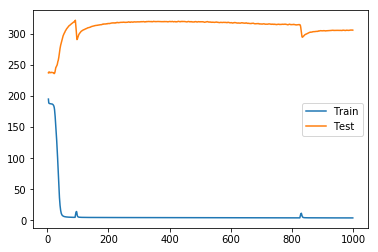

In [134]:
import pandas as pd

pd.DataFrame(np.array([loss_train[2:], loss_test[2:]]).T, columns=['Train', 'Test']).rolling(window=5).mean().plot()

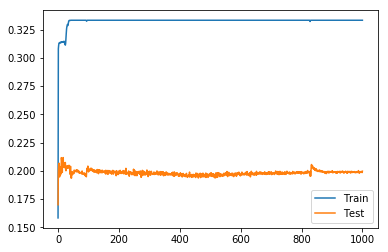

In [139]:
pd.DataFrame(np.array([causality_train, causality_test]).T, columns=['Train', 'Test']).rolling(window=1).mean().plot()

### Ball-springs experiments

In [3]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

if args.suffix[:4] == '_kur':
    train_loader, valid_loader, test_loader = load_kuramoto_data(path=args.path,
                                                                 batch_size=args.batch_size,
                                                                 suffix=args.suffix)
else:
    train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_data(path=args.path,
                                                                                            batch_size=args.batch_size,
                                                                                            suffix=args.suffix,
                                                                                            stationary=args.stationary,
                                                                                            shuffle=True, 
                                                                                            data_type='positions', 
                                                                                            binary=not 'continuous' in args.suffix)

args.num_atoms, args.timesteps, args.in_dim = train_loader.dataset[0][0].shape
args.total_dim = args.num_atoms*args.in_dim

In [18]:
rnn_encoder = nn.GRU(args.num_atoms*args.in_dim, 64, num_layers=2, batch_first=True, bidirectional=True)
out_encoder = nn.ModuleList([nn.Linear(128, args.num_atoms**2) for _ in range(args.lag)])

if args.cuda:
    rnn_encoder = rnn_encoder.cuda()
    out_encoder = out_encoder.cuda()
    
optimizer_encoder = optim.Adam(list(rnn_encoder.parameters()) + list(out_encoder.parameters()))

init_weights(rnn_encoder)
init_weights(out_encoder)

In [19]:
loss_train, loss_test = [test(-1, rnn_encoder, out_encoder, train_loader)[-1]], [test(-1, rnn_encoder, out_encoder, test_loader)[-1]]
causality_train, causality_test = [causality_estimation(rnn_encoder, out_encoder, train_loader)], [causality_estimation(rnn_encoder, out_encoder, test_loader)]

for epoch in range(args.epochs_adam):
    loss_train.append(train(epoch, rnn_encoder, out_encoder, optimizer_encoder, train_loader))
    loss_test.append(test(epoch, rnn_encoder, out_encoder, test_loader))
    causality_train.append(causality_estimation(rnn_encoder, out_encoder, train_loader)[-1])
    causality_test.append(causality_estimation(rnn_encoder, out_encoder, test_loader)[-1])

Epoch: -001 loss: 31.08250 reg: 1.48598
Epoch: -001 loss: 152.89076 reg: 1.53002
Epoch: 0000 loss: 7.57349 reg: 943.65827
Epoch: 0000 loss: 2.95818 reg: 1203.88642
Epoch: 0001 loss: 1.20136 reg: 1646.93928
Epoch: 0001 loss: 1.90198 reg: 2294.82944
Epoch: 0002 loss: 0.38476 reg: 4606.41288
Epoch: 0002 loss: 0.24405 reg: 6637.08384
Epoch: 0003 loss: 0.04748 reg: 6224.95970
Epoch: 0003 loss: 0.45082 reg: 5951.07997
Epoch: 0004 loss: 0.03440 reg: 5626.24659
Epoch: 0004 loss: 0.08369 reg: 5325.72674
Epoch: 0005 loss: 0.02601 reg: 5064.99142
Epoch: 0005 loss: 0.13062 reg: 4811.17055
Epoch: 0006 loss: 0.02238 reg: 4579.57368
Epoch: 0006 loss: 0.25332 reg: 4332.23136
Epoch: 0007 loss: 0.01763 reg: 4191.06538
Epoch: 0007 loss: 0.06595 reg: 4019.24319
Epoch: 0008 loss: 0.01539 reg: 3873.40043
Epoch: 0008 loss: 0.10616 reg: 3739.38384
Epoch: 0009 loss: 0.01379 reg: 3623.84693
Epoch: 0009 loss: 0.06381 reg: 3511.56479
Epoch: 0010 loss: 0.01999 reg: 3420.93376
Epoch: 0010 loss: 0.05338 reg: 3383.11

Epoch: 0097 loss: 0.00888 reg: 2813.32711
Epoch: 0097 loss: 0.05733 reg: 2808.67642
Epoch: 0098 loss: 0.00778 reg: 2815.11472
Epoch: 0098 loss: 0.05489 reg: 2812.91488
Epoch: 0099 loss: 0.00976 reg: 2816.24843
Epoch: 0099 loss: 0.25002 reg: 2795.91017
Epoch: 0100 loss: 0.01510 reg: 2806.39710
Epoch: 0100 loss: 0.04334 reg: 2810.86149
Epoch: 0101 loss: 0.00769 reg: 2813.18489
Epoch: 0101 loss: 0.04809 reg: 2811.37580
Epoch: 0102 loss: 0.00713 reg: 2815.64622
Epoch: 0102 loss: 0.03729 reg: 2823.03941
Epoch: 0103 loss: 0.00720 reg: 2818.45278
Epoch: 0103 loss: 0.05175 reg: 2813.71190
Epoch: 0104 loss: 0.00752 reg: 2820.66790
Epoch: 0104 loss: 0.03744 reg: 2835.88231
Epoch: 0105 loss: 0.00735 reg: 2822.71359
Epoch: 0105 loss: 0.03713 reg: 2831.39780
Epoch: 0106 loss: 0.00782 reg: 2824.43584
Epoch: 0106 loss: 0.04278 reg: 2834.63320
Epoch: 0107 loss: 0.00797 reg: 2823.25326
Epoch: 0107 loss: 0.07318 reg: 2821.98597
Epoch: 0108 loss: 0.00809 reg: 2822.16676
Epoch: 0108 loss: 0.04648 reg: 281

Epoch: 0195 loss: 0.00187 reg: 2827.60424
Epoch: 0195 loss: 0.02974 reg: 2829.61700
Epoch: 0196 loss: 0.00200 reg: 2830.25916
Epoch: 0196 loss: 0.06478 reg: 2840.79136
Epoch: 0197 loss: 0.00447 reg: 2826.33164
Epoch: 0197 loss: 0.03401 reg: 2827.26345
Epoch: 0198 loss: 0.00197 reg: 2829.23961
Epoch: 0198 loss: 0.02960 reg: 2829.97760
Epoch: 0199 loss: 0.00256 reg: 2830.90849
Epoch: 0199 loss: 0.05919 reg: 2821.71016
Epoch: 0200 loss: 0.00314 reg: 2829.08513
Epoch: 0200 loss: 0.03191 reg: 2833.53470
Epoch: 0201 loss: 0.00201 reg: 2830.78109
Epoch: 0201 loss: 0.03111 reg: 2832.66433
Epoch: 0202 loss: 0.00236 reg: 2832.18216
Epoch: 0202 loss: 0.03884 reg: 2831.00349
Epoch: 0203 loss: 0.00192 reg: 2832.95350
Epoch: 0203 loss: 0.03245 reg: 2831.84669
Epoch: 0204 loss: 0.00187 reg: 2834.62627
Epoch: 0204 loss: 0.02856 reg: 2836.39599
Epoch: 0205 loss: 0.00225 reg: 2834.92883
Epoch: 0205 loss: 0.03432 reg: 2838.77945
Epoch: 0206 loss: 0.00451 reg: 2830.92593
Epoch: 0206 loss: 0.03094 reg: 282

Epoch: 0293 loss: 0.00066 reg: 2836.44958
Epoch: 0293 loss: 0.04985 reg: 2836.67710
Epoch: 0294 loss: 0.00114 reg: 2835.66049
Epoch: 0294 loss: 0.05182 reg: 2832.86178
Epoch: 0295 loss: 0.00079 reg: 2836.09159
Epoch: 0295 loss: 0.06949 reg: 2833.19883
Epoch: 0296 loss: 0.00303 reg: 2831.39984
Epoch: 0296 loss: 0.05031 reg: 2832.86176
Epoch: 0297 loss: 0.00046 reg: 2833.16110
Epoch: 0297 loss: 0.05148 reg: 2835.42385
Epoch: 0298 loss: 0.00025 reg: 2834.92844
Epoch: 0298 loss: 0.05602 reg: 2836.37507
Epoch: 0299 loss: 0.00056 reg: 2835.72359
Epoch: 0299 loss: 0.06318 reg: 2833.98721
Epoch: 0300 loss: 0.00072 reg: 2835.59094
Epoch: 0300 loss: 0.05939 reg: 2834.37929
Epoch: 0301 loss: 0.00095 reg: 2835.88403
Epoch: 0301 loss: 0.06610 reg: 2835.54882
Epoch: 0302 loss: 0.00220 reg: 2834.22344
Epoch: 0302 loss: 0.11940 reg: 2829.15401
Epoch: 0303 loss: 0.00215 reg: 2831.19231
Epoch: 0303 loss: 0.07185 reg: 2831.22019
Epoch: 0304 loss: 0.00036 reg: 2833.09990
Epoch: 0304 loss: 0.06952 reg: 283

Epoch: 0391 loss: 0.00029 reg: 2834.32029
Epoch: 0391 loss: 0.02967 reg: 2836.56456
Epoch: 0392 loss: 0.00048 reg: 2835.11996
Epoch: 0392 loss: 0.02721 reg: 2834.24633
Epoch: 0393 loss: 0.00089 reg: 2834.74871
Epoch: 0393 loss: 0.03406 reg: 2833.41323
Epoch: 0394 loss: 0.00077 reg: 2834.43630
Epoch: 0394 loss: 0.02753 reg: 2832.02191
Epoch: 0395 loss: 0.00040 reg: 2834.52530
Epoch: 0395 loss: 0.02844 reg: 2832.39388
Epoch: 0396 loss: 0.00083 reg: 2834.65063
Epoch: 0396 loss: 0.04951 reg: 2832.30795
Epoch: 0397 loss: 0.00102 reg: 2833.91466
Epoch: 0397 loss: 0.02909 reg: 2831.08115
Epoch: 0398 loss: 0.00097 reg: 2834.45463
Epoch: 0398 loss: 0.03146 reg: 2832.07301
Epoch: 0399 loss: 0.00115 reg: 2833.71544
Epoch: 0399 loss: 0.03127 reg: 2832.18991
Epoch: 0400 loss: 0.00020 reg: 2834.46091
Epoch: 0400 loss: 0.02934 reg: 2832.62175
Epoch: 0401 loss: 0.00082 reg: 2834.60753
Epoch: 0401 loss: 0.03088 reg: 2831.64063
Epoch: 0402 loss: 0.00013 reg: 2835.18703
Epoch: 0402 loss: 0.02756 reg: 283

Epoch: 0489 loss: 0.00086 reg: 2834.66098
Epoch: 0489 loss: 0.03817 reg: 2833.24191
Epoch: 0490 loss: 0.00032 reg: 2835.13812
Epoch: 0490 loss: 0.03125 reg: 2833.27013
Epoch: 0491 loss: 0.00053 reg: 2835.55225
Epoch: 0491 loss: 0.04507 reg: 2833.95298
Epoch: 0492 loss: 0.00150 reg: 2834.46084
Epoch: 0492 loss: 0.04394 reg: 2832.62324
Epoch: 0493 loss: 0.00072 reg: 2833.92968
Epoch: 0493 loss: 0.03702 reg: 2833.49760
Epoch: 0494 loss: 0.00007 reg: 2834.61531
Epoch: 0494 loss: 0.03889 reg: 2836.33909
Epoch: 0495 loss: 0.00015 reg: 2835.19017
Epoch: 0495 loss: 0.03474 reg: 2836.08634
Epoch: 0496 loss: 0.00083 reg: 2834.67444
Epoch: 0496 loss: 0.03824 reg: 2834.27008
Epoch: 0497 loss: 0.00003 reg: 2835.25741
Epoch: 0497 loss: 0.03866 reg: 2836.67952
Epoch: 0498 loss: 0.00114 reg: 2834.73034
Epoch: 0498 loss: 0.03935 reg: 2833.75389
Epoch: 0499 loss: 0.00025 reg: 2834.83568
Epoch: 0499 loss: 0.04217 reg: 2835.77038
Epoch: 0500 loss: 0.00111 reg: 2834.08773
Epoch: 0500 loss: 0.03645 reg: 283

Epoch: 0587 loss: 0.00014 reg: 2835.01573
Epoch: 0587 loss: 0.07263 reg: 2837.97633
Epoch: 0588 loss: 0.00045 reg: 2834.96415
Epoch: 0588 loss: 0.07035 reg: 2836.72406
Epoch: 0589 loss: 0.00022 reg: 2835.01020
Epoch: 0589 loss: 0.07441 reg: 2837.39164
Epoch: 0590 loss: 0.00048 reg: 2835.13662
Epoch: 0590 loss: 0.09590 reg: 2839.53164
Epoch: 0591 loss: 0.00098 reg: 2834.36734
Epoch: 0591 loss: 0.12559 reg: 2837.15946
Epoch: 0592 loss: 0.00042 reg: 2834.50117
Epoch: 0592 loss: 0.06912 reg: 2839.18085
Epoch: 0593 loss: 0.00052 reg: 2836.21276
Epoch: 0593 loss: 0.09314 reg: 2837.16838
Epoch: 0594 loss: 0.00030 reg: 2836.12298
Epoch: 0594 loss: 0.09705 reg: 2838.15792
Epoch: 0595 loss: 0.00005 reg: 2836.46036
Epoch: 0595 loss: 0.08929 reg: 2839.03605
Epoch: 0596 loss: 0.00006 reg: 2836.81245
Epoch: 0596 loss: 0.08912 reg: 2839.46905
Epoch: 0597 loss: 0.00016 reg: 2836.85510
Epoch: 0597 loss: 0.09023 reg: 2839.55468
Epoch: 0598 loss: 0.00002 reg: 2837.04855
Epoch: 0598 loss: 0.08979 reg: 284

Epoch: 0685 loss: 0.00032 reg: 2836.42896
Epoch: 0685 loss: 0.07847 reg: 2837.76898
Epoch: 0686 loss: 0.00029 reg: 2836.12769
Epoch: 0686 loss: 0.08372 reg: 2839.33067
Epoch: 0687 loss: 0.00059 reg: 2835.92134
Epoch: 0687 loss: 0.08794 reg: 2837.99210
Epoch: 0688 loss: 0.00046 reg: 2835.85382
Epoch: 0688 loss: 0.28513 reg: 2848.76737
Epoch: 0689 loss: 0.00354 reg: 2833.44065
Epoch: 0689 loss: 0.11144 reg: 2836.38197
Epoch: 0690 loss: 0.00006 reg: 2834.74415
Epoch: 0690 loss: 0.08954 reg: 2837.37798
Epoch: 0691 loss: 0.00001 reg: 2835.29539
Epoch: 0691 loss: 0.08627 reg: 2839.31667
Epoch: 0692 loss: 0.00002 reg: 2835.86896
Epoch: 0692 loss: 0.08543 reg: 2840.16622
Epoch: 0693 loss: 0.00024 reg: 2835.77139
Epoch: 0693 loss: 0.08870 reg: 2839.38947
Epoch: 0694 loss: 0.00035 reg: 2835.60756
Epoch: 0694 loss: 0.09284 reg: 2839.31085
Epoch: 0695 loss: 0.00038 reg: 2835.48348
Epoch: 0695 loss: 0.08517 reg: 2840.61216
Epoch: 0696 loss: 0.00030 reg: 2835.63121
Epoch: 0696 loss: 0.08804 reg: 284

Epoch: 0783 loss: 0.00108 reg: 2835.30874
Epoch: 0783 loss: 0.11280 reg: 2835.22442
Epoch: 0784 loss: 0.00013 reg: 2835.35170
Epoch: 0784 loss: 0.13192 reg: 2837.68940
Epoch: 0785 loss: 0.00012 reg: 2835.56674
Epoch: 0785 loss: 0.13809 reg: 2837.06958
Epoch: 0786 loss: 0.00001 reg: 2835.95696
Epoch: 0786 loss: 0.13769 reg: 2838.28273
Epoch: 0787 loss: 0.00002 reg: 2836.50929
Epoch: 0787 loss: 0.14618 reg: 2839.08908
Epoch: 0788 loss: 0.00007 reg: 2836.72854
Epoch: 0788 loss: 0.14450 reg: 2839.31917
Epoch: 0789 loss: 0.00025 reg: 2836.65618
Epoch: 0789 loss: 0.15475 reg: 2839.17600
Epoch: 0790 loss: 0.00081 reg: 2835.80859
Epoch: 0790 loss: 0.14710 reg: 2837.81252
Epoch: 0791 loss: 0.00054 reg: 2834.91464
Epoch: 0791 loss: 0.19330 reg: 2838.89269
Epoch: 0792 loss: 0.00002 reg: 2835.27405
Epoch: 0792 loss: 0.19404 reg: 2839.81438
Epoch: 0793 loss: 0.00048 reg: 2835.44296
Epoch: 0793 loss: 0.16712 reg: 2838.70557
Epoch: 0794 loss: 0.00035 reg: 2835.41134
Epoch: 0794 loss: 0.20855 reg: 284

Epoch: 0881 loss: 0.00015 reg: 2835.59382
Epoch: 0881 loss: 0.14694 reg: 2839.82266
Epoch: 0882 loss: 0.00026 reg: 2835.70092
Epoch: 0882 loss: 0.16131 reg: 2840.07496
Epoch: 0883 loss: 0.00029 reg: 2835.50892
Epoch: 0883 loss: 0.15809 reg: 2840.93700
Epoch: 0884 loss: 0.00041 reg: 2835.19829
Epoch: 0884 loss: 0.17487 reg: 2838.90325
Epoch: 0885 loss: 0.00010 reg: 2835.38916
Epoch: 0885 loss: 0.16724 reg: 2840.13526
Epoch: 0886 loss: 0.00051 reg: 2835.73087
Epoch: 0886 loss: 0.17148 reg: 2838.67910
Epoch: 0887 loss: 0.00075 reg: 2835.57545
Epoch: 0887 loss: 0.06378 reg: 2835.74126
Epoch: 0888 loss: 0.00021 reg: 2836.36800
Epoch: 0888 loss: 0.16786 reg: 2839.72446
Epoch: 0889 loss: 0.00011 reg: 2836.88385
Epoch: 0889 loss: 0.15995 reg: 2840.49627
Epoch: 0890 loss: 0.00061 reg: 2836.33117
Epoch: 0890 loss: 0.18213 reg: 2840.77016
Epoch: 0891 loss: 0.00013 reg: 2836.11700
Epoch: 0891 loss: 0.17756 reg: 2840.73085
Epoch: 0892 loss: 0.00075 reg: 2835.77295
Epoch: 0892 loss: 0.20084 reg: 284

Epoch: 0979 loss: 0.00065 reg: 2835.99113
Epoch: 0979 loss: 0.15550 reg: 2834.47686
Epoch: 0980 loss: 0.00031 reg: 2835.33986
Epoch: 0980 loss: 0.15921 reg: 2838.36266
Epoch: 0981 loss: 0.00015 reg: 2835.49656
Epoch: 0981 loss: 0.14801 reg: 2839.42700
Epoch: 0982 loss: 0.00031 reg: 2835.41151
Epoch: 0982 loss: 0.14600 reg: 2839.10225
Epoch: 0983 loss: 0.00007 reg: 2835.66731
Epoch: 0983 loss: 0.13118 reg: 2838.79514
Epoch: 0984 loss: 0.00022 reg: 2835.57556
Epoch: 0984 loss: 0.17696 reg: 2838.58145
Epoch: 0985 loss: 0.00049 reg: 2835.74699
Epoch: 0985 loss: 0.19526 reg: 2839.89628
Epoch: 0986 loss: 0.00049 reg: 2835.19350
Epoch: 0986 loss: 0.13697 reg: 2837.88988
Epoch: 0987 loss: 0.00134 reg: 2834.81362
Epoch: 0987 loss: 0.28453 reg: 2842.04586
Epoch: 0988 loss: 0.00013 reg: 2834.99274
Epoch: 0988 loss: 0.16226 reg: 2840.38061
Epoch: 0989 loss: 0.00017 reg: 2835.72093
Epoch: 0989 loss: 0.14710 reg: 2840.15148
Epoch: 0990 loss: 0.00003 reg: 2836.35820
Epoch: 0990 loss: 0.17410 reg: 284

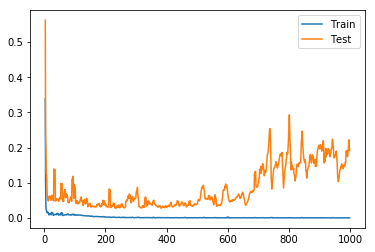

In [35]:
import pandas as pd

pd.DataFrame(np.array([loss_train[2:], loss_test[2:]]).T, columns=['Train', 'Test']).rolling(window=5).mean().plot()

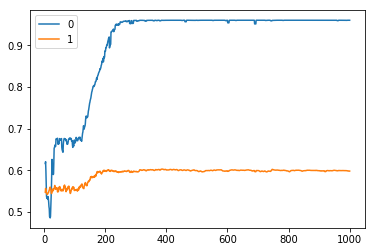

In [34]:
pd.DataFrame(np.array([causality_train, causality_test]).T, columns=['Train', 'Test']).rolling(window=5).mean().plot()